<a href="https://colab.research.google.com/github/AmbiTyga/Task-Stylumia/blob/Basic/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Kaggle Download
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c stumbleupon

Saving kaggle.json to kaggle.json
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 40.1MB/s]
 97% 153M/157M [00:12<00:00, 9.05MB/s]
100% 157M/157M [00:12<00:00, 13.2MB/s]
100% 8.02M/8.02M [00:02<00:00, 3.50MB/s]

  0% 0.00/3.45M [00:00<?, ?B/s]
100% 3.45M/3.45M [00:00<00:00, 114MB/s]


In [2]:
!unzip -q /content/raw_content.zip

In [3]:
!git clone https://github.com/misja/python-boilerpipe.git
%cd python-boilerpipe
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

Cloning into 'python-boilerpipe'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 30.06 KiB | 669.00 KiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/python-boilerpipe
     |████████████████████████████████| 460kB 12.2MB/s 
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/boilerpipe
copying src/boilerpipe/__init__.py -> build/lib/boilerpipe
creating build/lib/boilerpipe/extract
copying src/boilerpipe/extract/__init__.py -> build/lib/boilerpipe/extract
creating build/lib/boilerpipe/data
creating build/lib/boilerpipe/data/boilerpipe-1.2.0
copying src/boilerpipe/data/boilerpipe-1.2.0/boilerpipe-1.2.0.jar -> build/lib/boilerpipe/data/boilerpipe-1.2.0
creating build/lib/boilerpipe/data/boilerpipe-1.2.0/lib
copying s

In [30]:
import pandas as pd 
import numpy as np
import json
from bs4 import BeautifulSoup
import re
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from boilerpipe.extract import Extractor

## Preprocessing Functions

In [5]:
def extract_domain(df_url):
    # extract domains
    domain = df_url.str.lower().apply(lambda x:x.split('/')[2])
    domain_parts = domain.str.split('.')

    return domain_parts.apply(lambda x:'.'.join(x[-2:]) if x[-2] not in ['com', 'co'] else '.'.join(x[-3:]))

In [6]:
def clean_string(s):
  s = re.sub(r'[\r\n\t]', ' ',s)
  s = re.sub(r"\s+", ' ', s)
  return s.strip()

In [7]:
def boil_soup(urlid):
    filename = '/content/raw_content/' + urlid

    with open(filename, 'rb') as f:
        html = f.read()

        for parser in ["lxml", "xml", "html5lib"]:
            soup = BeautifulSoup(html, parser)
            if soup.body:
                return soup

        return BeautifulSoup(html)

In [9]:
def get_title(id):
  
  TAGS_REMOVE = ['script', 'style']
  
  soup = boil_soup(id)


  for el in soup.find_all(TAGS_REMOVE):
    el.extract()
  
  texts = soup.find_all('title')
  texts = [clean_string(x.text) for x in texts]

  try:
    return texts[np.argmax([len(x.split()) for x in texts])]
  except ValueError:
    return np.nan

## Dataset

In [10]:
data = pd.concat([pd.read_csv('/content/train.tsv.zip',sep = '\t'),
                  pd.read_csv('/content/test.tsv.zip',sep = '\t')],ignore_index = True)

In [11]:
item = data.copy()

## Feature Extraction

In [12]:
item['real_url'] = item['url'].str.lower()
item['domain'] = extract_domain(item['real_url'])
item['tld'] = item['domain'].str.split('.').apply(lambda x:x[-1])

In [13]:
item['body'] = item['boilerplate'].apply(lambda x:json.loads(x)['body'])
item.rename(columns = {'url':'org_url'},inplace = True)

item.drop(columns = ['boilerplate'],inplace = True)

In [14]:
item['boilerpipe'] = item['urlid'].astype(str).apply(get_boiled)
item['title'] = item['urlid'].astype(str).apply(get_title)
item['boilerplate'] = item[['title','body']].values.tolist()

In [54]:
item.to_json("Final_parsed.json")

# Exploration

In [52]:
train = item.dropna(subset=['label'])
test = item[item['label'].isna()]

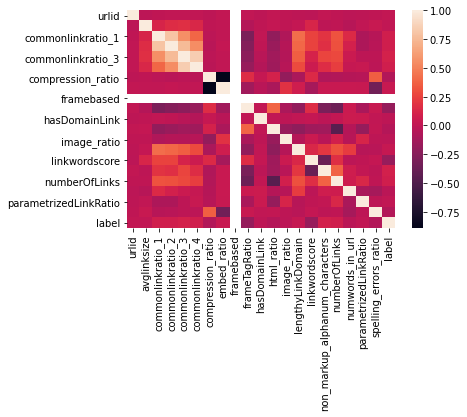

In [53]:
sns.heatmap(train.corr())

In [37]:
px.histogram(train, x='alchemy_category', color="label", barmode='group')